# DATABASE PROJECT GROUP 1
## OUTLINE
### I. Preparation

1. Connect to the database

2. Create table 

3. Clean data and insert into database

### II. SQL Implementation

  ##### A. Basic (Shown in file document)

  ##### B. Advanced

   1. Views (Shown in file document)

   2. Triggers and functions (Shown in file document)

   3. Transactions (Shown in file document)
   
   4. Analysis

In [95]:
import psycopg2
from psycopg2 import Error
import sqlalchemy
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I.Preparation

In [107]:
# Credentials
user = "group_1_2024"
password = ""
host = ""
port = ""
database_name = "group_1_2024"

### 1. Connect to the database

In [108]:
# Connect to the database
try:
    conn = psycopg2.connect(database = database_name,user=user, password=password, host=host, port=port)
    conn.autocommit = True
    cursor = conn.cursor()
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

### 2. Create tables

In [103]:
def run_sql_from_file(path, connection, psql_cursor):
    sql_code = open(path).read()
    # Execute the SQL code
    try:
        psql_cursor.execute(sql_code)
        print("SQL commands operate successfully")
    except Exception as e:
        connection.rollback()
        print(f"An error occurred: {e}")


In [104]:
# Local path - should be modified to test
create_table_path = "/Users/tueeee/Downloads/project-red-cross-main/code/create_table.sql"

In [105]:
# Create tables
run_sql_from_file(create_table_path, conn, cursor)

An error occurred: relation "city" already exists



### 3. Clean data and insert into database

In [99]:
# Convert the data into dataframe and checking NULL values
file_path = "/Users/tueeee/Downloads/project-red-cross-main/data/data.xlsx"
excel_file = pd.ExcelFile(file_path)
df = {}
for sheet_name in excel_file.sheet_names:
    df[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name)
    
for sheet_name, data in df.items():
    null_values = data.isnull().any().any()
    print(f"Sheet '{sheet_name}' has null values: {null_values}")

Sheet 'city' has null values: False
Sheet 'volunteer' has null values: False
Sheet 'volunteer_range' has null values: False
Sheet 'skill' has null values: False
Sheet 'skill_assignment' has null values: False
Sheet 'interest' has null values: False
Sheet 'interest_assignment' has null values: False
Sheet 'beneficiary' has null values: False
Sheet 'request' has null values: False
Sheet 'request_skill' has null values: False
Sheet 'request_location' has null values: False
Sheet 'volunteer_application' has null values: False


In [88]:
# Clean data - added 'interest' column in request table
def map_title_to_interest(title):
    title = title.lower()
    if 'work in team' in title:
        return 'WorkInATeam'
    else: 
        words = title.split()
        words = [word for word in words if word.lower() != "needed"]
        return ''.join(word.capitalize() for word in words)

df['request']['interest'] = df['request']['title'].apply(map_title_to_interest)
print(df['request'].head())

#all_interests_match = df['request']['interest'].isin(df['interest']['name']).all()
#print(all_interests_match)   USE FOR DEBUGGING


   id                     title  beneficiary_id  number_of_volunteers  \
0   1       work in team needed               3                    14   
1   2    work with young needed               9                    25   
2   3    guide and teach needed               9                    31   
3   4    guide and teach needed               5                    19   
4   5  work with elderly needed               4                    23   

   priority_value          start_date            end_date    register_by_date  \
0               1 2024-07-25 22:15:00 2024-07-28 18:00:00 2024-07-18 01:00:00   
1               3 2022-05-31 04:15:00 2022-06-01 17:00:00 2022-05-17 04:00:00   
2               2 2024-07-22 22:15:00 2024-07-27 17:30:00 2024-07-12 06:00:00   
3               1 2024-09-25 02:30:00 2024-09-25 18:30:00 2024-09-17 02:59:00   
4               2 2021-03-01 01:15:00 2021-03-07 18:45:00 2021-02-15 09:30:00   

          interest  
0      WorkInATeam  
1    WorkWithYoung  
2    GuideA

In [89]:
# Insert the data into to the database
def insert_dataframe_to_sql_table(dataframe, table_name, connection, cursor):
    # Generate the columns and values for the insert statement
    columns = ', '.join(dataframe.columns)
    values = ', '.join(['%s'] * len(dataframe.columns))
    insert_statement = f"INSERT INTO {table_name} ({columns}) VALUES ({values})"

    # Insert each row
    for row in dataframe.itertuples(index=False, name=None):
        try:
            cursor.execute(insert_statement, row)
        except Exception as e:
            connection.rollback()
            print(f"An error occurred while inserting data into table '{table_name}': {e}")

for sheet_name, dataframe in df.items():
    insert_dataframe_to_sql_table(dataframe, sheet_name, conn, cursor)


## II. SQL implementation
### A. Basic (Shown in document)
### B. Advance

### 1. Views (Shown in file document)

### 2. Triggers and functions (Shown in file document)

### 3. Transactions (Shown in file document)

### 4. Analysis

#### Problem 1. (5p)

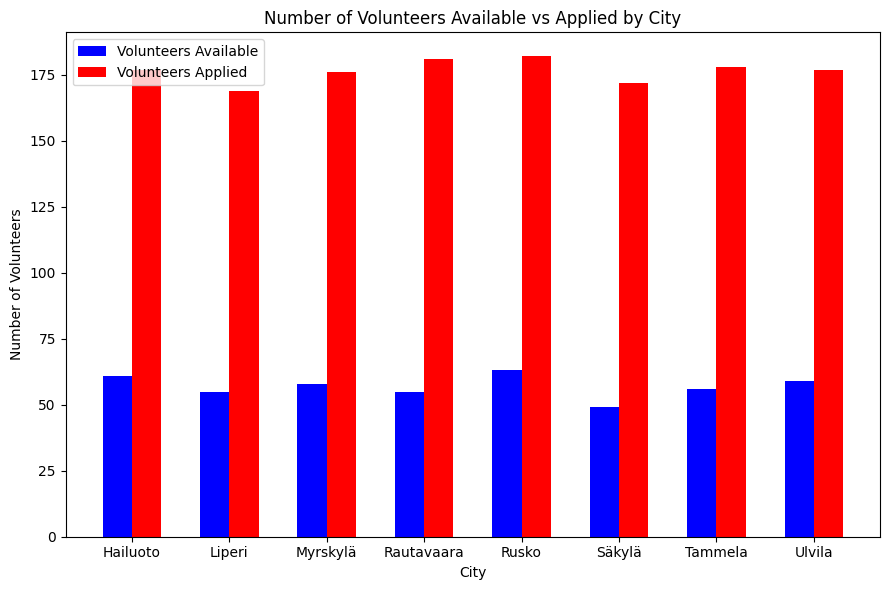

    city_name  volunteers_available  volunteers_applied
0    Hailuoto                    61                 177
1      Liperi                    55                 169
2    Myrskylä                    58                 176
3  Rautavaara                    55                 181
4       Rusko                    63                 182
5      Säkylä                    49                 172
6     Tammela                    56                 178
7      Ulvila                    59                 177

Top 2 cities with the most volunteers:
Rusko: 63 volunteers
Hailuoto: 61 volunteers

Bottom 2 cities with the least volunteers:
Rautavaara: 55 volunteers
Säkylä: 49 volunteers


In [100]:

# SQL query to calculate the number of volunteers available by city with city names
sql_volunteers_available = """
    SELECT 
        c.name AS city_name,
        COUNT(DISTINCT vr.volunteer_id) AS volunteers_available
    FROM 
        volunteer_range vr
    JOIN 
        city c ON vr.city_id = c.id
    GROUP BY 
        c.name
"""

# SQL query to calculate the number of volunteers that applied for requests in each city with city names
sql_volunteers_applied = """
    SELECT 
        c.name AS city_name,
        COUNT(DISTINCT va.volunteer_id) AS volunteers_applied
    FROM 
        volunteer_application va
    JOIN 
        request_location rl ON va.request_id = rl.request_id
    JOIN 
        city c ON rl.city_id = c.id
    WHERE 
        va.is_valid = TRUE
    GROUP BY 
        c.name
"""

# Execute the SQL queries
cursor.execute(sql_volunteers_available)
volunteers_available_data = cursor.fetchall()
cursor.execute(sql_volunteers_applied)
volunteers_applied_data = cursor.fetchall()

# Convert the fetched data into DataFrames
volunteers_available_df = pd.DataFrame(volunteers_available_data, columns=['city_name', 'volunteers_available'])
volunteers_applied_df = pd.DataFrame(volunteers_applied_data, columns=['city_name', 'volunteers_applied'])

# Merge the DataFrames on city_id to get a complete view
city_volunteers_df = volunteers_available_df.merge(volunteers_applied_df, on='city_name', how='outer').fillna(0)

# Visualization
plt.figure(figsize=(9, 6))
bar_width = 0.3
index = range(len(city_volunteers_df['city_name']))
plt.bar(index, city_volunteers_df['volunteers_available'], bar_width, label='Volunteers Available', color='b')
plt.bar([i + bar_width for i in index], city_volunteers_df['volunteers_applied'], bar_width, label='Volunteers Applied', color='r')
plt.xlabel('City')
plt.ylabel('Number of Volunteers')
plt.title('Number of Volunteers Available vs Applied by City')
plt.xticks([i + bar_width / 2 for i in index], city_volunteers_df['city_name'])
plt.legend()
plt.tight_layout()
plt.show()

# Print the DataFrame
print(city_volunteers_df)

# The city with the most (top 2) volunteers and the least (bottom 2)
sorted_data = sorted(zip(city_volunteers_df['city_name'], city_volunteers_df['volunteers_available']), key=lambda x: x[1], reverse=True)
top_cities = sorted_data[:2]
bottom_cities = sorted_data[-2:]
print("\nTop 2 cities with the most volunteers:")
for city, volunteers in top_cities:
    print(f"{city}: {volunteers} volunteers")
print("\nBottom 2 cities with the least volunteers:")
for city, volunteers in bottom_cities:
    print(f"{city}: {volunteers} volunteers")


#### Problem 2. (10p)
- The scoring matching system between a volunteer and a request is based on 4 categories: range, skills, interest, and the volunteer's travelreadiness. The weight of each category contributes respectively 35%, 35%, 20%, 10% to the final score. 
  
  + The range_score is calculated by dividing the volunteer's number of matched cities to the total number of cities that the request needs
  
  + The skill_score is calculated by finding matched skills and the assessment of the request to that skill. First, we find the matched skills that a volunteer has, then taking the sum of each of the skill's value. Finally, we divide it by the total possible score a votunteer can have, due to the assessment of the request to those skills.
  
  + The interest_score is basically 1 if the volunteer's interests contain the request's interest area, and 0 otherwise
  
  + The travel_readiness_score is calculated by dividing the minimum travel_readiness over the volunteers that apply to a specific request
to his travel_readiness. The more time he needs to be ready to travel, the less score he receives. 

- The scoring matching system may provide correct result, as it takes into consideration all aspects of the volunteer, and also the assessment of the request to those aspects. We consider the importance of the categories in the order: skill = range > interest > travelreadiness, which is reasonable as:
  
  + For example, a volunteer with interest into the request, but he does not have needed skills, should be evaluated with bad scores. Comparing to a volunteer with no interest into the request, but he still applies to it with great skills. Then, he should be evaluated with high scores.
  
  + For example, a volunteer, who needs much time to prepare for travel might cause delays to the work. However, it is still better if he can ensure his presence and appear to all the locations. Therefore, the range is weighted with high points.

- The top candidates for each request now is partially the same with those found in past questions. As now, we have considered more aspects, the results should be more accurate




In [110]:
sql_scoring_system_skill = """
    SELECT 
        va.volunteer_id,
        va.request_id,
        SUM(rs.value) AS matched_skill_score,
        total_request_score.total_score AS total_possible_score,
        ROUND(
            CASE 
                WHEN total_request_score.total_score = 0 THEN 0 
                ELSE SUM(rs.value)::FLOAT / total_request_score.total_score::FLOAT 
            END::NUMERIC, 2
        ) AS score_ratio
    FROM 
        volunteer_application va
    JOIN 
        skill_assignment sa ON va.volunteer_id = sa.volunteer_id
    JOIN 
        request_skill rs ON va.request_id = rs.request_id AND sa.skill_name = rs.skill_name
    JOIN (
        SELECT 
            request_id,
            SUM(value) AS total_score
        FROM 
            request_skill
        GROUP BY 
            request_id
    ) total_request_score ON va.request_id = total_request_score.request_id
    GROUP BY 
        va.volunteer_id, va.request_id, total_request_score.total_score;
"""

sql_scoring_system_range = """
    SELECT 
        va.volunteer_id,
        va.request_id,
        COUNT(DISTINCT vr.city_id) AS matched_cities_count,
        total_request_cities.total_city_count AS total_request_cities_count,
        ROUND(
            CASE 
                WHEN total_request_cities.total_city_count = 0 THEN 0
                ELSE CAST(COUNT(DISTINCT vr.city_id) AS NUMERIC) / CAST(total_request_cities.total_city_count AS NUMERIC)
            END, 2
        ) AS city_match_ratio
    FROM 
        volunteer_application va
    JOIN 
        volunteer_range vr ON va.volunteer_id = vr.volunteer_id
    JOIN 
        request_location rl ON va.request_id = rl.request_id AND vr.city_id = rl.city_id
    JOIN (
        SELECT 
            request_id,
            COUNT(DISTINCT city_id) AS total_city_count
        FROM 
            request_location
        GROUP BY 
            request_id
    ) total_request_cities ON va.request_id = total_request_cities.request_id
    GROUP BY 
        va.volunteer_id, va.request_id, total_request_cities.total_city_count;
"""

sql_scoring_system_interest_travelReadiness = """    
    SELECT
        va.volunteer_id,
        va.request_id,
        CASE
            WHEN req.interest IN (
                SELECT interest_name
                FROM interest_assignment
                WHERE volunteer_id = va.volunteer_id
            ) THEN 1
            ELSE 0
        END AS interest_matched,
        v.travel_readiness,
        ROUND(
            min_travel_readiness.min_travel_readiness/CAST(v.travel_readiness AS NUMERIC), 2
        ) AS normalized_travel_readiness
    FROM
        volunteer_application va
    JOIN
        request req ON va.request_id = req.id
    JOIN
        volunteer v ON va.volunteer_id = v.id
    JOIN (
        SELECT
            va.request_id,
            MIN(v.travel_readiness) AS min_travel_readiness
        FROM
            volunteer_application va
        JOIN
            volunteer v ON va.volunteer_id = v.id
        GROUP BY
            va.request_id
    ) min_travel_readiness ON va.request_id = min_travel_readiness.request_id;
"""

cursor.execute(sql_scoring_system_skill)
scoring_system_skill_df = pd.DataFrame(cursor.fetchall(), columns=['volunteer_id', 'request_id', 'matched_skill_score', 'total_score', 'skill_score_ratio'])

cursor.execute(sql_scoring_system_range)
scoring_system_range_df = pd.DataFrame(cursor.fetchall(), columns=['volunteer_id', 'request_id', 'matched_cities_count', 'total_cities_count', 'city_match_ratio'])

cursor.execute(sql_scoring_system_interest_travelReadiness)
scoring_system_interest_travelReadiness_df = pd.DataFrame(cursor.fetchall(), columns=['volunteer_id', 'request_id', 'interest_matched', 'travel_readiness', 'travel_readiness_ratio'])

merged_df = pd.merge(scoring_system_skill_df, scoring_system_range_df, on=['volunteer_id', 'request_id'])

scoring_system_df = pd.merge(merged_df, scoring_system_interest_travelReadiness_df, on=['volunteer_id', 'request_id'])
scoring_system_df['points'] = scoring_system_df['skill_score_ratio'] * 35 + scoring_system_df['city_match_ratio'] * 35 + scoring_system_df['interest_matched'] * 20 + scoring_system_df['travel_readiness_ratio'] * 10
scoring_system_df['points'] = pd.to_numeric(scoring_system_df['points'])

top_5_candidates = scoring_system_df.groupby('request_id').apply(lambda x: x.nlargest(5, 'points')).reset_index(drop=True)

#print(scoring_system_df[['volunteer_id', 'request_id', 'skill_score_ratio', 'city_match_ratio', 'travel_readiness_ratio', 'interest_matched',  'points']])


print(top_5_candidates[['volunteer_id', 'request_id', 'points']])



     volunteer_id  request_id  points
0     211074-9401           1   50.65
1     011074-9149           1   30.85
2     211099-910H           1   28.75
3     250681-919H           1   23.65
4     160903A941P           1   15.05
...           ...         ...     ...
1144  020759-9272         381   60.75
1145  100396-906V         382   51.15
1146  220490-940Y         382   48.55
1147  020759-9272         382   47.15
1148  200472-937X         382   28.55

[1149 rows x 3 columns]


/var/folders/0f/s9wq33q97413q_m4638c7wdr0000gn/T/ipykernel_85300/209607875.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_candidates = scoring_system_df.groupby('request_id').apply(lambda x: x.nlargest(5, 'points')).reset_index(drop=True)


#### Problem 3. (5p)
- The comparison between the number of applications and the number of requests per month is shown in the diagram

- The outputs about the difference, minimum and maximum are shown below

- Due to the Pearson correlation coefficient and the p-value calculated below, there seems to be a a relationship between the time of the year and number of requests and applications. There is a seasonal trend, which shows a significant increase in requests and volunteer applications during the summer months  (June, July, August, September). This is likely due to:
  + School and University Breaks: Students and teachers have more free time to volunteer.
  + Favorable Weather: Better weather supports outdoor activities and events requiring volunteers.
  + Vacation Season: People on vacation or with flexible schedules are more available for volunteering.
  + Increased Community Needs: Summer programs, camps, and events increase the demand for volunteers.


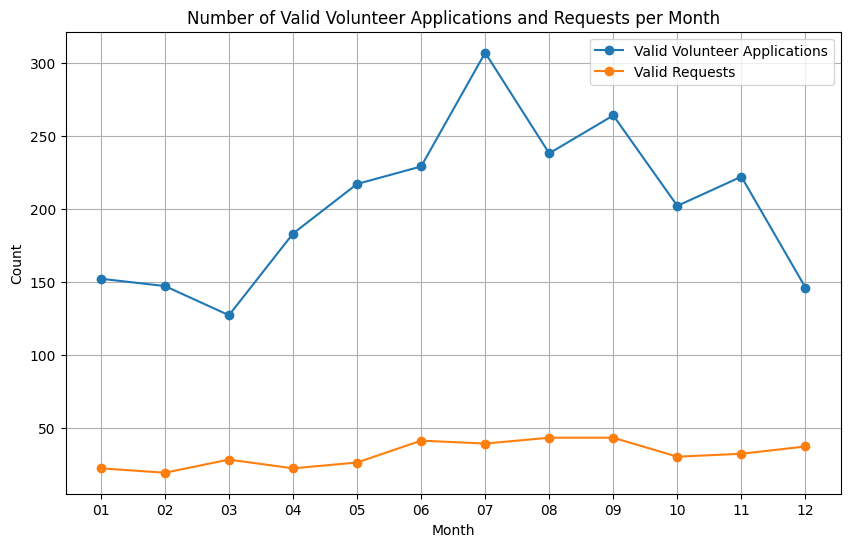

Most volunteer applications month: 07
Least volunteer applications month: 03
Most requests month: 08
Least requests month: 02

Difference between valid requests and volunteer applications for each month:
   month  difference
0     01         130
1     02         128
2     03          99
3     04         161
4     05         191
5     06         188
6     07         268
7     08         195
8     09         221
9     10         172
10    11         190
11    12         109


In [102]:
# SQL query to count valid volunteer applications for each month
sql_volunteer_applications = """
    SELECT TO_CHAR(va.modified, 'MM') AS month,
       COUNT(va.id) AS valid_volunteer_applications
    FROM volunteer_application va
    WHERE va.is_valid 
    GROUP BY month;

"""

# SQL query to count valid requests for each month
sql_requests = """
    SELECT TO_CHAR(r.start_date, 'MM') AS month,
        COUNT(r.id) AS valid_requests
    FROM request r
    GROUP BY month;
"""
cursor.execute(sql_volunteer_applications)
valid_volunteer_applications_per_month = pd.DataFrame(cursor.fetchall(), columns=['month', 'valid_volunteer_applications'])
cursor.execute(sql_requests)
valid_requests_per_month = pd.DataFrame(cursor.fetchall(), columns=['month', 'valid_requests'])

monthly_data = pd.merge(valid_volunteer_applications_per_month, valid_requests_per_month, on='month', how='outer')
monthly_data['difference'] = abs(monthly_data['valid_requests'] - monthly_data['valid_volunteer_applications'])
most_volunteer_applications_month = monthly_data.loc[monthly_data['valid_volunteer_applications'].idxmax()]['month']
least_volunteer_applications_month = monthly_data.loc[monthly_data['valid_volunteer_applications'].idxmin()]['month']
most_requests_month = monthly_data.loc[monthly_data['valid_requests'].idxmax()]['month']
least_requests_month = monthly_data.loc[monthly_data['valid_requests'].idxmin()]['month']

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['month'], monthly_data['valid_volunteer_applications'], marker='o', label='Valid Volunteer Applications')
plt.plot(monthly_data['month'], monthly_data['valid_requests'], marker='o', label='Valid Requests')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Valid Volunteer Applications and Requests per Month')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
# print(monthly_data) USE FOR DEBUGGING
print(f"Most volunteer applications month: {most_volunteer_applications_month}")
print(f"Least volunteer applications month: {least_volunteer_applications_month}")
print(f"Most requests month: {most_requests_month}")
print(f"Least requests month: {least_requests_month}")

print("\nDifference between valid requests and volunteer applications for each month:")
print(monthly_data[['month', 'difference']])


In [93]:
from scipy.stats import pearsonr

# Convert month to numeric
months = np.arange(1, 13)
differences = np.array(monthly_data['difference'])
# Calculate Pearson correlation
correlation, p_value = pearsonr(months, differences)

print(f"Pearson Correlation: {correlation}")
print(f"P-Value: {p_value}")


Pearson Correlation: 0.31776509146389975
P-Value: 0.3141660829516256


#### Problem 4. (5p) (Free choice): Analyse the number of volunteer applications and approval rates over time
- We tracks the number of volunteer applications and approval rates over time, providing insights into trends and the efficiency of the approval process. Monitoring these rates helps identify periods of high volunteer interest and ensures that applications are processed promptly, maintaining volunteer engagement.

- Due to the diagram below, we can see that though the number of applications fluctuates strongly over time, we have a dramatic increase in the number of upcoming requests. This leads to the fact that the we will need a hugh amount of volunteer in the future to meet the demand, which involves in the need of the organization to invest in marketing and promoting. 

- The approval rate seems to be stable with high rate between 75% to 100%. This suggests that the approval policy is reasonable, thus encouraging new volunteer to participate in.

- In general, this shows that we might need to expand and recruite a huge amount of volunteer for the upcoming requests. The approve policy seems to be reasonable and do not need to be modified now.


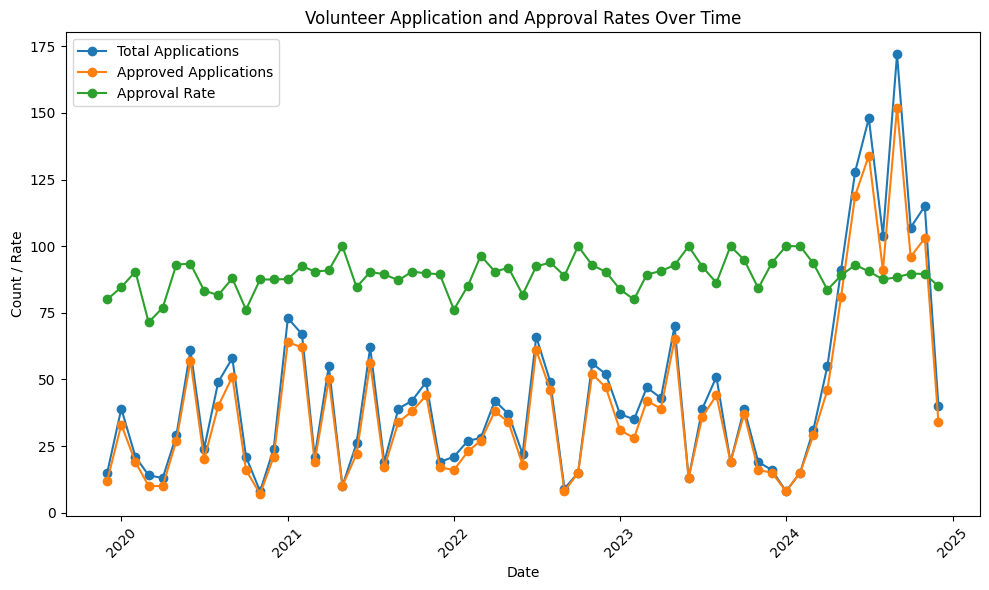

In [94]:
sql = """
    SELECT 
        EXTRACT(YEAR FROM va.modified) AS year,
        EXTRACT(MONTH FROM va.modified) AS month,
        COUNT(va.id) AS total_applications,
        COUNT(CASE WHEN va.is_valid = TRUE THEN 1 END) AS approved_applications,
        ROUND(COUNT(CASE WHEN va.is_valid = TRUE THEN 1 END)::NUMERIC / COUNT(va.id) * 100, 2) AS approval_rate
    FROM 
        volunteer_application va
    GROUP BY 
        EXTRACT(YEAR FROM va.modified), EXTRACT(MONTH FROM va.modified)
    ORDER BY 
        year DESC, month DESC;
"""
cursor.execute(sql)
approval_rate_df = pd.DataFrame(cursor.fetchall(), columns=['year', 'month', 'total_application', 'approved_application', 'approval_rate'])
approval_rate_df['date'] = pd.to_datetime(approval_rate_df[['year', 'month']].assign(day=1))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(approval_rate_df['date'], approval_rate_df['total_application'], label='Total Applications', marker='o')
plt.plot(approval_rate_df['date'], approval_rate_df['approved_application'], label='Approved Applications', marker='o')
plt.plot(approval_rate_df['date'], approval_rate_df['approval_rate'], label='Approval Rate', marker='o')

plt.xlabel('Date')
plt.ylabel('Count / Rate')
plt.title('Volunteer Application and Approval Rates Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#print(approval_rate_df)   USE FOR DEBUGGING
